In [1]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:

env = gym.make("CarRacing-v0")

In [4]:
class ReplayMemory:
    #rotating buffer of size N
    def __init__(self,N,batch_size=5000):
        self.memory = []
        self.size = N
        self.batch_size =batch_size
    
    def add(self,experience):
        self.memory.append(experience)
        if(len(self.memory) > self.size):
            del self.memory[0]
    
    def replay(self):    
        #if(len(self.memory) < self.batch_size):
        #    return []
        #relay everything stored in small minibatches 
        # (currently of lenght 1)
        # in a random order to reduce correlation
        output = np.array(self.memory)
        np.random.shuffle(output)
        return output[:self.batch_size]

#Define what our experience looks like
#[state,action,reward,next_state]

In [5]:
# DQN network from this tutorial 
# https://towardsdatascience.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288
# We will probably tweak this but our main interesting part is training this model
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(7056, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        if(type(x) != torch.Tensor):
            x = torch.Tensor([[x]])
            x = x.float()
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
def grayscale_frame(frame):
    return np.mean(frame,axis=2)

def get_best_action(model,state):
    #get our best action from our learner
    #print("state given:",state)
    action = model.forward(state).detach().numpy()[0]
    #action = int(action)
    #print("State:",state,"Action:",action)
    action =  np.array(action)
    return action

In [7]:
def learn_from_data(model,target,data,optim):
    for experience in data:
        #compute the loss from
        state,action,reward,next_state = experience
        
        
        
        
        #belman equation
        
        chosen_action_based_on_reward = model.forward(state)
        expected_reward = reward + target.forward(next_state).detach_()
        
        loss = F.l1_loss(chosen_action_based_on_reward,expected_reward)
        #we want the chosen_action based on reward to match 
        #the reward of being in the next state and the reward given
        
        #print(reward)
        
        # must zero gradients before backprop
        # for pytorch
        optim.zero_grad()
        model.zero_grad()
        loss.backward()
        optim.step()
    return model

In [8]:
def select_action(exploration_rate,state,model):
    uniform_random_variable= random.uniform(0,1)
        
    if(uniform_random_variable > exploration_rate):
        
        #state = torch.tensor([[state]])
        #state=state.float()

        action = get_best_action(model,state)
        
    else:
        #other wise explore randomly
        action = env.action_space.sample()
    return action

In [9]:
def update_target(model,target):
    target.load_state_dict(model.state_dict())
    #print("model:",model.state_dict())
    #print("target:",target.state_dict())
    return target

In [10]:
# Run the training loop
# Currently we do not have a target network but we could do that
num_episodes = 1000000
training_episodes = 2
target_episodes = 15
# network_update_epochs = 100 #use this if using a target network
game_length = 10000

# exploration rate, we want our network to explore 
# sometimes but not all the time, to do this
# we use a decaying exploration rate
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01
# this bit of code will determine the decay
# exploration_rate = min_exploration_rate + \
#        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)

In [11]:
replay_memory = ReplayMemory(100000)
dqn = DQN()#96,96)
target = DQN()
optimizer = optim.SGD(dqn.parameters(),lr=.01)
print(dqn)

DQN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=7056, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [12]:
target = update_target(dqn,target)

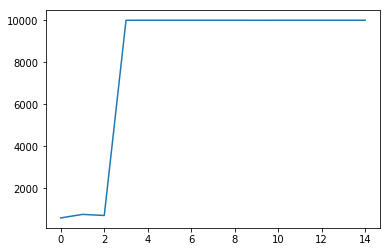

exploration_rate: 0.8706646530448178
Training on Experience


In [ ]:
rewards = []
for episode in range(num_episodes):
    print("Episode:",episode)
    state= env.reset()
    state = grayscale_frame(state)
    
    episode_reward = 0
    tko_timer = 0
    game = []
    
    for step in range(game_length):
        #env.render() #sadly we have to render this env
        
        action = select_action(exploration_rate,state,dqn)
        
        prev_state = state
        
        state, reward, done, info = env.step(action)
        
        if(reward <= -.1):
            tko_timer +=1
            
        else:
            tko_timer = 0
            
        #remove the negative constant penalty
        reward = int(10*reward + 1)
        state = grayscale_frame(state)
        
        experience= [prev_state,action,reward,state]
        game.append(experience)
        
        
        
        
        #replay_memory.add(experience)
        
        #tracking how far we are getting
        episode_reward +=reward
        
        if(done or tko_timer >=100):
            # if we haven't gotten a positive reward 
            # in the last 20 steps 
            # or the game is over: stop
            if(step > 25):
                [replay_memory.add(e) for e in game]
            break
        
    
    #end of episode variable unm pdating
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    
    rewards.append(episode_reward)
    clear_output(wait=True)
    plt.plot(rewards)
    plt.show()
    print("exploration_rate:",exploration_rate)
    
    if(episode%training_episodes == 0 and episode != 0):
        print("Training on Experience")
        dqn = learn_from_data(dqn,target,replay_memory.replay(),optimizer)
    if(episode%target_episodes ==0):
        print("updating the target network")
        target = update_target(dqn,target)
    